# Blog Post: Logistic Regression
## Introduction
First of all, here is a link to my LogisticRegression source code: https://github.com/ShadowedSpace/ShadowedSpace.github.io/blob/main/posts/BP7/LogisticRegression.py

In this blog post, I aim to perform several experiments on the above posted logistic regression source code. The first experiment will be vanilla gradient descent, to get a better understanding of whether my source code works, and what it means for it to work. Then, I will implement momentum, and compare the efficiency of the first two experiments. Finally, I will do an experiment to show the danger of overfitting and that it doesn't generalize well.

In [2]:
%load_ext autoreload
%autoreload 2
from LogisticRegression import LogisticRegression, GradientDescentOptimizer
import torch
from matplotlib import pyplot as plt 
import numpy as np

In [3]:
# generates data for classification problem

def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points, p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    return X, y

X, y = classification_data(noise = 0.5)

w = torch.linspace(-1, 1, X.shape[1])
w_prev = torch.linspace(-1, 1, X.shape[1])

In [4]:
# plots data and boundary decision based on w
# only works for dimension = 2

def plot_data_and_boundary(X, y, w, ax=None):
    if ax is None:
        fig, ax = plt.subplots()

    # Plot the data
    targets = [0, 1]
    markers = ["o", ","]
    colors = ["red", "blue"]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = colors[i], cmap = "BrBG", marker = markers[i])

    # Draw the decision boundary
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x_values = torch.linspace(x_min, x_max, 100)
    y_values = -(w[0]*x_values + w[2])/w[1]
    ax.plot(x_values, y_values, color='black')

    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")
    plt.show()

In [5]:
def pad(X):
    return np.append(X, np.ones((X.shape[0], 1)), 1)

In [6]:
# calculates the accuracy of a model

def accuracy(y_pred, y_true):
    correct = (y_pred == y_true).sum()
    total = y_true.shape[0]
    print(correct)
    return correct / total

#### Experiment 1
This first experiment is to implement "vanilla gradient descent." Its main purpose is to ensure that the LogisticRegression and GradientDescentOptimizer classes are properly implemented. The intent is to show that tw looks visually correct, and the loss decreases monotonically.

Text(0, 0.5, 'Loss')

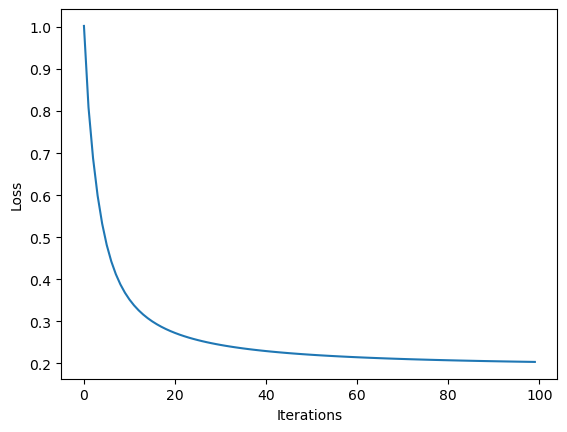

In [7]:
# vanilla gradient descent

LR = LogisticRegression(w)
opt = GradientDescentOptimizer(LR, w, w_prev)

losses = []

for _ in range(100):
    losses.append(LR.loss(X, y))
    opt.step(X, y, alpha = 1.5, beta = 0)

plt.plot(losses)
plt.xlabel("Iterations")
plt.ylabel("Loss")

Ok nice! It looks like the losses indeed converge, so that's exciting to see. It looks like it takes around 70 steps to even out.

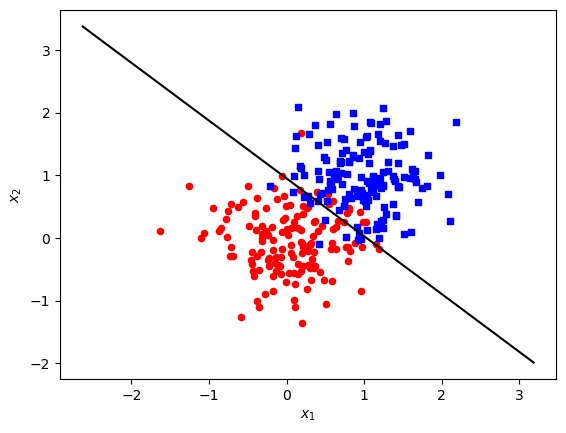

In [8]:
plot_data_and_boundary(X, y, LR.w)

That's a solid decision boundary. Probably pretty close to what my human eye could make out as the best linear decision boundary.

In [9]:
# Predict the labels
y_pred = LR.predict(X)

# Calculate the accuracy
acc = accuracy(y_pred, y)
print(f'Accuracy: {acc}')

tensor(273)
Accuracy: 0.9100000262260437


#### Experiment 2
The second experiment is to better learn how momentum impacts logistic regression. With a proper selection of beta, it should converge even faster than vanilla gradient descent.

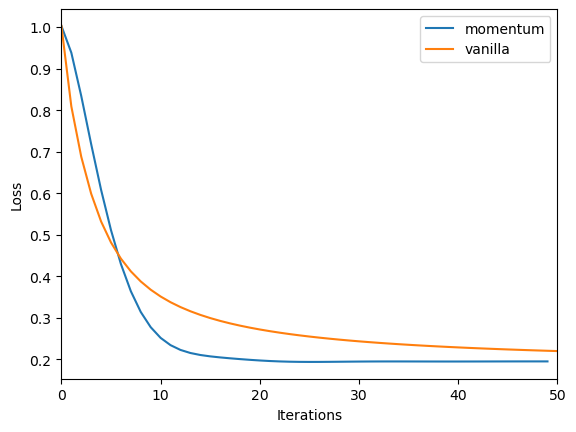

In [10]:
# momentum

w2 = torch.linspace(-1, 1, X.shape[1])
w_prev2 = torch.linspace(-1, 1, X.shape[1])

LR2 = LogisticRegression(w)
opt2 = GradientDescentOptimizer(LR2, w2, w_prev2)

losses_mom = []

for _ in range(50):
    losses_mom.append(LR2.loss(X, y))
    opt2.step(X, y, alpha = 0.45, beta = 0.9)

plt.plot(losses_mom, label = "momentum")
plt.plot(losses, label = "vanilla")
plt.xlim(0, 50)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

Woah - LR with momentum is totally worth the extra term. This converged after only about 15 steps (in comparison to ~70 without momentum).

In [11]:
# Predict the labels
y_pred2 = LR2.predict(X)

# Calculate the accuracy
acc = accuracy(y_pred2, y)
print(f'Accuracy: {acc}')

tensor(273)
Accuracy: 0.9100000262260437


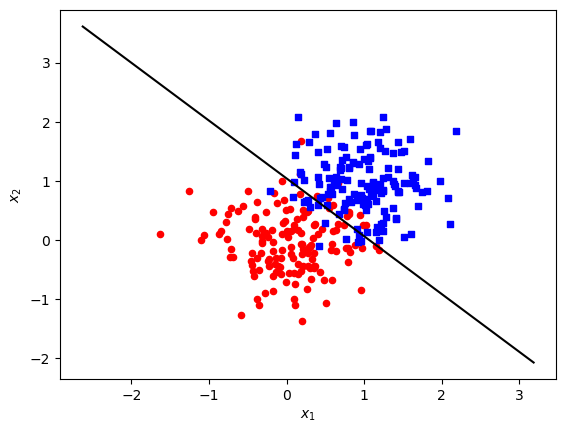

In [12]:
plot_data_and_boundary(X, y, LR2.w)

#### Experiment 3
The third and final experiment is to look into the effects of overfitting. To do this, I will generate two data sets through exactly the same method, and fit the training set on an absurdly high number of dimensions to see what impact this has on the test set. I would expecet the accuracy to decrease noticeably.

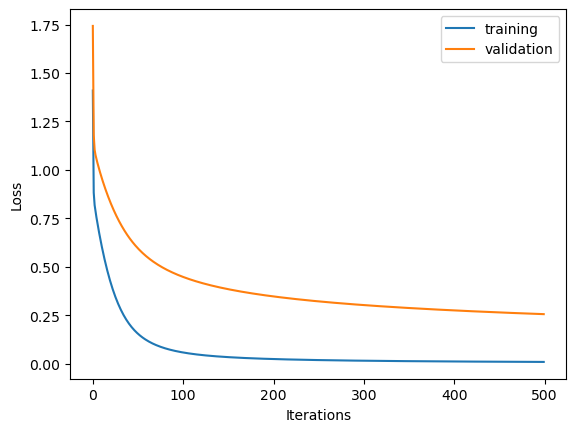

In [13]:
# overfitting

X_train, y_train = classification_data(n_points = 75, noise = 0.5, p_dims = 100)
X_val, y_val = classification_data(n_points = 75, noise = 0.5, p_dims = 100)
X_test, y_test = classification_data(n_points = 75, noise = 0.5, p_dims = 100)

w3 = torch.linspace(-1, 1, X_train.shape[1])
w_prev3 = torch.linspace(-1, 1, X_train.shape[1])

LR3 = LogisticRegression(w3)
opt = GradientDescentOptimizer(LR3, w3, w_prev3)

losses = []
losses_val = []

for _ in range(500):
    losses.append(LR3.loss(X_train, y_train))
    losses_val.append(LR3.loss(X_val, y_val))
    opt.step(X_train, y_train, alpha = 0.15, beta = 0.2)

plt.plot(losses, label = "training")
plt.plot(losses_val, label = "validation")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

Here, I plot the losses of the train set (blue) and the losses of the validation set (orange) as the logistic regression algorithm steps. As predicted, because of the high number of dimensions, while the losses for the train set converge rather quickly, while the losses of the validation set do not converge.

In [14]:
# Predict the labels
y_pred_train = LR3.predict(X_train)

# Calculate the accuracy
acc = accuracy(y_pred_train, y_train)
print(f'Accuracy: {acc}')

tensor(75)
Accuracy: 1.0


An astounding accuracy of 100% on the training test. I sure would hope so with more dimensions than data points.

In [15]:
# Predict the labels
y_pred_test = LR3.predict(X_test)

# Calculate the accuracy
acc = accuracy(y_pred_test, y_test)
print(f'Accuracy: {acc}')

tensor(67)
Accuracy: 0.8933333158493042


Looks like we (successfully) overfit from the less than satisfactory 92% accuracy on the test set. While more dimensions than necessary can get an impressive result on the training set, it doesn't generalize so well.

## Conclusion
Well, I agree with Phil --- that was a pretty cool blog post. I definitely struggled some of the more challenging bits (especially plots and vectorized operations), but looking back at my accomplishment, I am proud of the learning I did. I have a much better understanding of how logistic regression works as a classifier, and how to show this in the form of loss graphs and data visualization. I also learned about the use of a validation set to track loss on a "test" set without touching the test set, which is a pretty neat comment. My first experiment (vanilla gradient descent) showed that the loss monotonically decreases. The momentum experiment showed that logistic regression can be further optimized. Finally, the overfitting experiment showed that too many dimensions can decrease accuracy when generalizing to unknown data.